# CNN-based Fashion MNIST classifier
By **Sudharshan P J**

In [ ]:
'''
HEADERS
'''

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from torch.utils.data import DataLoader, RandomSampler
import torch.optim as optim
from torchvision import datasets, transforms
import torch.optim.lr_scheduler as lr_scheduler
import numpy as np
import os
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from torchsummary import summary
import pandas as pd

In [ ]:
'''
DEFINE PATH & VARIABLES
'''

# Change below constants if needed

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 13

RANDOM_SEED = 12345

DATASET_ROOT = './'
SAVED_MODEL_DIR = './saved_models'
SAVED_IMAGE_DIR = './saved_imgs'
SAVED_SUMMARY_DIR = './saved_summary'
DATASET_MEAN = (0.5)
DATASET_STD = (0.5)
BATCH_SIZE = 100
NUM_EPOCHS = 10
NUM_WORKERS = 2
LEARNING_RATE = 0.001
SAVE_MODEL = True
DROPOUT_PVALS = [0.0, 0.5, 0.7, 0.9, 0.99, 0.999]

In [ ]:
# Creates directory if does not exist
if not os.path.exists(SAVED_MODEL_DIR):
    os.makedirs(SAVED_MODEL_DIR)

if not os.path.exists(SAVED_SUMMARY_DIR):
    os.makedirs(SAVED_SUMMARY_DIR)

if not os.path.exists(SAVED_IMAGE_DIR):
    os.makedirs(SAVED_IMAGE_DIR)

# Random seed set
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Plot configs
plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)   # fontsize of the figure title

In [ ]:
'''
MODEL
'''

class CNNModel(nn.Module):
    def __init__(self, dropout_p=0.5):
        """
        Initializes a Convolutional based classication network for Fashion MNIST.

        ...

        Attributes
        ----------
        dropout_p : float, optional (default: ``0.5``)
            Dropout probability for the network layers
        """

        super(CNNModel, self).__init__()
        # set up class attributes useful in building the network and inference

        # Convolution Layer 1
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=0)
        self.relu1 = nn.ReLU()

        # Convolution Layer 2
        self.cnn2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=0)
        self.relu2 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)

        # Fully connected Layer 1
        self.fc1 = nn.Linear(64*12*12, 128)
        self.relu3 = nn.ReLU()
        self.dropout1 = nn.Dropout(p=dropout_p)

        # Fully connected Layer 2 (readout)
        self.fc2 = nn.Linear(128, 10)
    
    def forward(self, x):
        """
        Forward prop data through the network and return the preds.

        Parameters
        ----------
            x : Tensor of dimension (b, h, w)
                Batch of images of size - (h,w)

        Returns
        -------
            out : Tensor of dimension (b, num_classes)
                predictions (logits) of the model
        """

        # Convolution 1
        out = self.cnn1(x)
        out = self.relu1(out)

        # Convolution 2 
        out = self.cnn2(out)
        out = self.relu2(out)
        out = self.maxpool1(out)

        # Resize for FC1
        out = out.view(out.size(0), -1)

        # Fully connected Layer 1
        out = self.fc1(out)
        out = self.relu3(out)
        out = self.dropout1(out)

        # Fully connected Layer 2 (readout)
        out = self.fc2(out)

        return out

In [ ]:
'''
MODEL PARAMETERS CHECK
'''

def check_model(model):
    """
    Prints a string summarizing the network

    Parameters
    ----------
        model: Class definition
            Class where the neural net is initialized

    Returns
    -------
    None
    """

    summary(model, (1, 28, 28))

In [ ]:
'''
CHECKED
'''

check_model(CNNModel().cuda())

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
              ReLU-2           [-1, 32, 26, 26]               0
            Conv2d-3           [-1, 64, 24, 24]          18,496
              ReLU-4           [-1, 64, 24, 24]               0
         MaxPool2d-5           [-1, 64, 12, 12]               0
            Linear-6                  [-1, 128]       1,179,776
              ReLU-7                  [-1, 128]               0
           Dropout-8                  [-1, 128]               0
            Linear-9                   [-1, 10]           1,290
Total params: 1,199,882
Trainable params: 1,199,882
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.97
Params size (MB): 4.58
Estimated Total Size (MB): 5.55
---------------------------------------

In [ ]:
'''
MODEL TRAINER
'''

def train_CNNmodel(train_loader, test_loader, num_epochs=10, learning_rate=0.001, 
                   dropout_p=0.5, use_scheduler=False, save_model=False):
    """
    Trains the CNN model for the classification task using Adam optimizer and Cross Entropy Loss.
    Saves the model after ``num_epochs`` epochs along with the accuracy and loss statistics.

    Displays a nice training progress bar with epoch statistics.
    See `https://tqdm.github.io/docs/notebook/` documentation page for more details.

    Parameters
    ----------
        train_loader : Class DataLoader
             Provides an iterable over the train dataset
        test_loader : Class DataLoader
             Provides an iterable over the test dataset
        num_epochs : int, optional (default: ``10``)
            Number of epochs to run
        learning_rate : float, optional (default: ``0.001``)
            learning rate for the optimizer
        dropout_p : float, optional (default: ``0.5``)
            Dropout probability for the network layers
        use_scheduler : bool, optional (default: ``False``)
            If ``True``, learning rate scheduler is used
        save_model : bool, optinal (default: ``False``)
            Set to ``True`` if the model has to be saved

    Returns
    -------
    None
    """
    
    train_nepochs_loss = []
    test_nepochs_loss = []
    test_nepochs_accuracy = []

    # INSTANTIATE MODEL INSTANCE
    model = CNNModel(dropout_p=dropout_p).cuda()

    # INSTANTIATE LOSS INSTANCE
    criterion = nn.CrossEntropyLoss()

    # INSTANTIATE OPTIMIZER CLASS
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    if use_scheduler:
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer, len(train_loader))

    print('\nSETTINGS')
    print(f'TOTAL #EPOCHS: {num_epochs}; LEARNING RATE: {learning_rate}; DROPOUT PROBABILITY: {dropout_p}')

    for epoch in range(1, num_epochs+1):
        train_loss = []
        test_loss = []

        with tqdm(total=len(train_loader.dataset), desc=f'Epoch {epoch}/{num_epochs}', 
                unit='images', position=0, leave=True) as pbar:

            for batch_idx, (images, labels) in enumerate(train_loader):
                images = images.cuda()
                labels = labels.cuda()
                
                # Clear gradients w.r.t. parameters
                optimizer.zero_grad()

                # Forward pass to get output/logits
                outputs = model(images)

                # Calculate Loss: softmax --> cross entropy loss
                loss = criterion(outputs, labels)
                pbar.set_postfix(**{'train loss (batch)': loss.item()})

                # Getting gradients w.r.t. parameters
                loss.backward()

                # Updating parameters
                optimizer.step()
                
                train_loss.append(loss.item())
                pbar.update(images.shape[0])

            # Learning rate scheduler
            if use_scheduler:
                scheduler.step()

            train_loss_mean = np.mean(train_loss)

        # Iterate through test dataset
        with torch.no_grad():  
            num_correct = 0
            num_total = 0

            for images, labels in test_loader:
                images = images.cuda()
                labels = labels.cuda()
                
                # Forward pass only to get logits/output
                outputs = model(images)
                
                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)

                loss = criterion(outputs, labels)
                test_loss.append(loss.item())

                # Total number of labels
                num_total += labels.size(0)
                
                num_correct += (predicted == labels).sum()

            test_loss_mean = np.mean(test_loss)
            test_accuracy = (num_correct.item()/num_total)*100
            
        # Print Loss
        epoch_output = '[EPOCH: {}/{}] Train Loss: {:.4f}; Test Loss: {:.4f}; Test Accuracy: {:.4f} %'
        print(epoch_output.format(epoch, num_epochs, train_loss_mean, test_loss_mean, test_accuracy))
        train_nepochs_loss.append(train_loss_mean)
        test_nepochs_loss.append(test_loss_mean)
        test_nepochs_accuracy.append(test_accuracy)
    
    print(80*'#') # End marker

    stat_summary = pd.DataFrame({'train_loss':train_nepochs_loss, 
                        'test_loss':test_nepochs_loss, 
                        'test_accuracy':test_nepochs_accuracy})
    
    summary_filename = f'ne{num_epochs}lr{learning_rate}dp{dropout_p}'
    stat_summary.to_csv(os.path.join(SAVED_SUMMARY_DIR, f'{summary_filename}.csv'), index=False)
    
    # Save model
    if SAVE_MODEL:
        model_filename = f'{summary_filename}.pth'
        torch.save(model.state_dict(), os.path.join(SAVED_MODEL_DIR, model_filename))

In [ ]:
'''
MAIN RUNNER
'''

if __name__ == "__main__":
    """
    Train and Test Transforms are defined along with their respective dataloader.
    Runs the function `train_CNNmodel` for different dropout probabilities
    """

    train_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(), # RandomHorizontalFlip Data Augmentation
        transforms.ToTensor(), 
        transforms.Normalize(DATASET_MEAN, DATASET_STD)
    ])
    
    test_transform = transforms.Compose([ 
        transforms.ToTensor(), 
        transforms.Normalize(DATASET_MEAN, DATASET_STD)
    ])

    train_set = datasets.FashionMNIST(root=DATASET_ROOT, train=True, 
                                      transform=train_transform, download=True)

    test_set = datasets.FashionMNIST(root=DATASET_ROOT, train=False, 
                                     transform=test_transform)

    train_loader = DataLoader(dataset=train_set, 
                              batch_size=BATCH_SIZE, 
                              shuffle=True, 
                              num_workers=NUM_WORKERS)

    test_loader = DataLoader(dataset=test_set, 
                             batch_size=BATCH_SIZE, 
                             shuffle=False, 
                             num_workers=NUM_WORKERS)

    for pvals in DROPOUT_PVALS:
        train_CNNmodel(train_loader, test_loader, num_epochs=NUM_EPOCHS, learning_rate=LEARNING_RATE, 
                       dropout_p=pvals, use_scheduler=False, save_model=SAVE_MODEL)

Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw


Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw


Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw




Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw
Processing...
Done!

SETTINGS
TOTAL #EPOCHS: 10; LEARNING RATE: 0.001; DROPOUT PROBABILITY: 0.0


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)



[EPOCH: 1/10] Train Loss: 0.4204; Test Loss: 0.3405; Test Accuracy: 87.9800 %



[EPOCH: 2/10] Train Loss: 0.2629; Test Loss: 0.2592; Test Accuracy: 90.5700 %



[EPOCH: 3/10] Train Loss: 0.2172; Test Loss: 0.2353; Test Accuracy: 91.4800 %



[EPOCH: 4/10] Train Loss: 0.1817; Test Loss: 0.2452; Test Accuracy: 91.0700 %



[EPOCH: 5/10] Train Loss: 0.1590; Test Loss: 0.2393; Test Accuracy: 91.4400 %



[EPOCH: 6/10] Train Loss: 0.1370; Test Loss: 0.2305; Test Accuracy: 92.0300 %



[EPOCH: 7/10] Train Loss: 0.1168; Test Loss: 0.2270; Test Accuracy: 92.2200 %



[EPOCH: 8/10] Train Loss: 0.1000; Test Loss: 0.2272; Test Accuracy: 92.7400 %



[EPOCH: 9/10] Train Loss: 0.0871; Test Loss: 0.2388; Test Accuracy: 92.5000 %



[EPOCH: 10/10] Train Loss: 0.0722; Test Loss: 0.2505; Test Accuracy: 92.4400 %
################################################################################

SETTINGS
TOTAL #EPOCHS: 10; LEARNING RATE: 0.001; DROPOUT PROBABILITY: 0.5



[EPOCH: 1/10] Train Loss: 0.5483; Test Loss: 0.4280; Test Accuracy: 84.9100 %



[EPOCH: 2/10] Train Loss: 0.3553; Test Loss: 0.3361; Test Accuracy: 88.2700 %



[EPOCH: 3/10] Train Loss: 0.2970; Test Loss: 0.3113; Test Accuracy: 89.0500 %



[EPOCH: 4/10] Train Loss: 0.2688; Test Loss: 0.2943; Test Accuracy: 89.8500 %



[EPOCH: 5/10] Train Loss: 0.2453; Test Loss: 0.2812; Test Accuracy: 90.0600 %



[EPOCH: 6/10] Train Loss: 0.2248; Test Loss: 0.2984; Test Accuracy: 90.0900 %



[EPOCH: 7/10] Train Loss: 0.2128; Test Loss: 0.2794; Test Accuracy: 90.5900 %



[EPOCH: 8/10] Train Loss: 0.1970; Test Loss: 0.2781; Test Accuracy: 90.6700 %



[EPOCH: 9/10] Train Loss: 0.1851; Test Loss: 0.2851; Test Accuracy: 90.7900 %



[EPOCH: 10/10] Train Loss: 0.1738; Test Loss: 0.2681; Test Accuracy: 91.2600 %
################################################################################

SETTINGS
TOTAL #EPOCHS: 10; LEARNING RATE: 0.001; DROPOUT PROBABILITY: 0.7



[EPOCH: 1/10] Train Loss: 0.6619; Test Loss: 0.5010; Test Accuracy: 82.2400 %



[EPOCH: 2/10] Train Loss: 0.4423; Test Loss: 0.4275; Test Accuracy: 84.7700 %



[EPOCH: 3/10] Train Loss: 0.3834; Test Loss: 0.3923; Test Accuracy: 86.3300 %



[EPOCH: 4/10] Train Loss: 0.3428; Test Loss: 0.3674; Test Accuracy: 87.6500 %



[EPOCH: 5/10] Train Loss: 0.3186; Test Loss: 0.3461; Test Accuracy: 87.9100 %



[EPOCH: 6/10] Train Loss: 0.2970; Test Loss: 0.3395; Test Accuracy: 87.7800 %



[EPOCH: 7/10] Train Loss: 0.2814; Test Loss: 0.3239; Test Accuracy: 88.6700 %



[EPOCH: 8/10] Train Loss: 0.2665; Test Loss: 0.3268; Test Accuracy: 88.6900 %



[EPOCH: 9/10] Train Loss: 0.2610; Test Loss: 0.3304; Test Accuracy: 88.7200 %



[EPOCH: 10/10] Train Loss: 0.2494; Test Loss: 0.3221; Test Accuracy: 88.9900 %
################################################################################

SETTINGS
TOTAL #EPOCHS: 10; LEARNING RATE: 0.001; DROPOUT PROBABILITY: 0.9



[EPOCH: 1/10] Train Loss: 1.2216; Test Loss: 1.0333; Test Accuracy: 56.4300 %



[EPOCH: 2/10] Train Loss: 0.9579; Test Loss: 0.9126; Test Accuracy: 62.2900 %



[EPOCH: 3/10] Train Loss: 0.8667; Test Loss: 0.8679; Test Accuracy: 64.6700 %



[EPOCH: 4/10] Train Loss: 0.8162; Test Loss: 0.8172; Test Accuracy: 66.5700 %



[EPOCH: 5/10] Train Loss: 0.7774; Test Loss: 0.7883; Test Accuracy: 67.6200 %



[EPOCH: 6/10] Train Loss: 0.7508; Test Loss: 0.7801; Test Accuracy: 68.8400 %



[EPOCH: 7/10] Train Loss: 0.7323; Test Loss: 0.7607; Test Accuracy: 70.3700 %



[EPOCH: 8/10] Train Loss: 0.7104; Test Loss: 0.7500; Test Accuracy: 70.1200 %



[EPOCH: 9/10] Train Loss: 0.6960; Test Loss: 0.7166; Test Accuracy: 71.5900 %



[EPOCH: 10/10] Train Loss: 0.6820; Test Loss: 0.6984; Test Accuracy: 72.6000 %
################################################################################

SETTINGS
TOTAL #EPOCHS: 10; LEARNING RATE: 0.001; DROPOUT PROBABILITY: 0.99



[EPOCH: 1/10] Train Loss: 2.1742; Test Loss: 2.1048; Test Accuracy: 15.9600 %



[EPOCH: 2/10] Train Loss: 2.0753; Test Loss: 2.0466; Test Accuracy: 17.1500 %



[EPOCH: 3/10] Train Loss: 2.0456; Test Loss: 2.0171; Test Accuracy: 17.4100 %



[EPOCH: 4/10] Train Loss: 2.0252; Test Loss: 2.0274; Test Accuracy: 17.4300 %



[EPOCH: 5/10] Train Loss: 2.0172; Test Loss: 2.0041; Test Accuracy: 18.1200 %



[EPOCH: 6/10] Train Loss: 2.0093; Test Loss: 2.0136; Test Accuracy: 17.4200 %



[EPOCH: 7/10] Train Loss: 2.0023; Test Loss: 2.0039; Test Accuracy: 17.9000 %



[EPOCH: 8/10] Train Loss: 2.0029; Test Loss: 1.9930; Test Accuracy: 18.1000 %



[EPOCH: 9/10] Train Loss: 1.9979; Test Loss: 2.0062; Test Accuracy: 17.5600 %



[EPOCH: 10/10] Train Loss: 1.9966; Test Loss: 1.9903; Test Accuracy: 18.2100 %
################################################################################

SETTINGS
TOTAL #EPOCHS: 10; LEARNING RATE: 0.001; DROPOUT PROBABILITY: 0.999



[EPOCH: 1/10] Train Loss: 2.3246; Test Loss: 2.3025; Test Accuracy: 10.0200 %



[EPOCH: 2/10] Train Loss: 2.3029; Test Loss: 2.3026; Test Accuracy: 10.0000 %



[EPOCH: 3/10] Train Loss: 2.3027; Test Loss: 2.3026; Test Accuracy: 10.0000 %



[EPOCH: 4/10] Train Loss: 2.3027; Test Loss: 2.3026; Test Accuracy: 10.0000 %



[EPOCH: 5/10] Train Loss: 2.3027; Test Loss: 2.3026; Test Accuracy: 10.0000 %



[EPOCH: 6/10] Train Loss: 2.3027; Test Loss: 2.3026; Test Accuracy: 10.0000 %



[EPOCH: 7/10] Train Loss: 2.3027; Test Loss: 2.3026; Test Accuracy: 10.0000 %



[EPOCH: 8/10] Train Loss: 2.3027; Test Loss: 2.3026; Test Accuracy: 10.0000 %



[EPOCH: 9/10] Train Loss: 2.3027; Test Loss: 2.3026; Test Accuracy: 10.0000 %



[EPOCH: 10/10] Train Loss: 2.3027; Test Loss: 2.3026; Test Accuracy: 10.0000 %
################################################################################


  * We have saved the trained model after 10th epoch along with its accuracy & loss statistics.
  * This saved model can later be used for deployment or further training starting from 10th epoch onwards
  * The obtained accuracy and loss statistics can be used to visualize the model performance at a later stage

In [ ]:
'''
STATS PLOTTING
'''

def plot_test_eval(num_epochs, learning_rate, dropout_pvals, loss_or_accuracy='accuracy'):
    """
    Loads the loss or accuracy statistics and plots the curve - (test accuracy vs epochs) 
    or (test loss vs epochs) for different dropouts.

    Parameters
    ----------
        num_epochs : int
            Number of epochs to run
        learning_rate : float
            learning rate for the optimizer
        dropout_pvals : list
            List of Dropout probabilies (float)
        loss_or_accuracy : str, optional (default: ``accuracy``)
            Choose any of [``accuracy``,``loss``]

    Returns
    -------
    None
    """

    plt.figure(figsize=(12, 8))
    x_ticks = np.arange(1,num_epochs+1)

    for pvals in dropout_pvals:
        stat_summary = pd.read_csv(os.path.join(SAVED_SUMMARY_DIR, 
                                                f'ne{num_epochs}lr{learning_rate}dp{pvals}.csv'))
        plt.plot(x_ticks, stat_summary[f'test_{loss_or_accuracy}'], marker='d', label=f'p={pvals}')

    plt.legend(title='Dropout', loc='best')
    plt.title('Test Set Evaluation')
    plt.xlabel('Epochs')
    percent_sym = '(%)' if loss_or_accuracy=='accuracy' else ''
    plt.ylabel(f'{loss_or_accuracy} {percent_sym}')
    plt.savefig(os.path.join(SAVED_IMAGE_DIR, f'test_{loss_or_accuracy}.svg'))
    plt.xticks(x_ticks)
    plt.grid()
    plt.show()

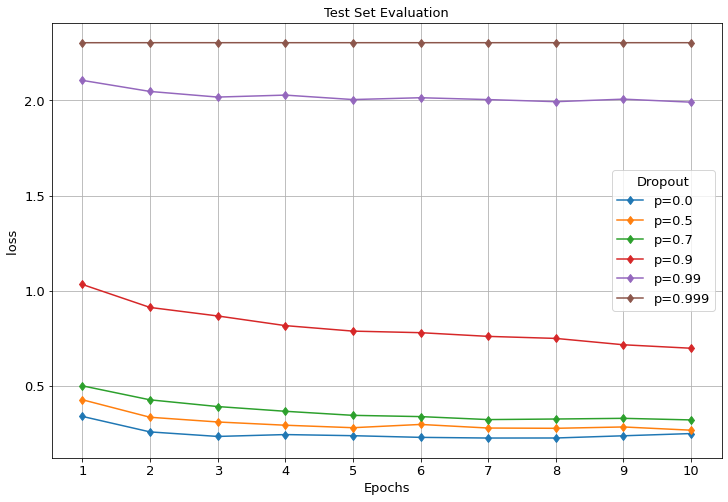

In [ ]:
'''
PLOTTING TEST LOSS
'''

plot_test_eval(num_epochs=NUM_EPOCHS, learning_rate=LEARNING_RATE, 
                    dropout_pvals=DROPOUT_PVALS, loss_or_accuracy='loss')

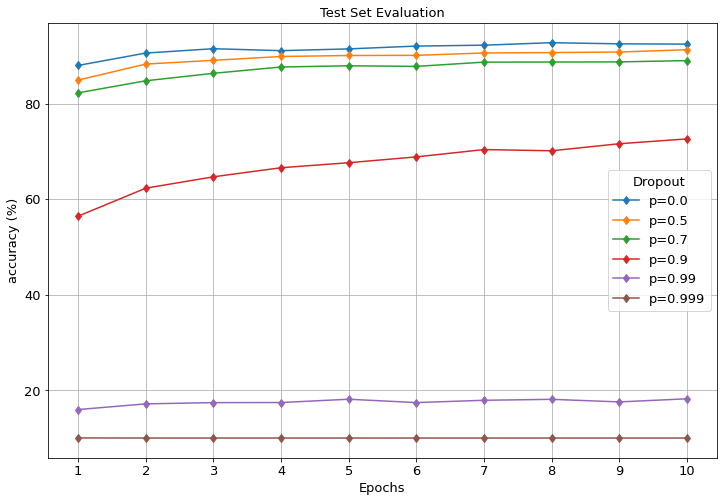

In [ ]:
'''
PLOTTING TEST ACCURACY
'''

plot_test_eval(num_epochs=NUM_EPOCHS, learning_rate=LEARNING_RATE, 
                    dropout_pvals=DROPOUT_PVALS, loss_or_accuracy='accuracy')

### From above, we can clearly see that the best model is the one with droput probability = 0.0

In [ ]:
'''
IMAGE, PREDICTED AND TRUE LABELS
'''

def load_and_display(num_epochs=10, learning_rate=0.001, dropout_p=0.0):
    """
    Loads the saved model, invokes the dataloader, randomly evaluates on 5 samples 
    of the test set and displys the images with the true and predicted labels.

    Parameters
    ----------
        num_epochs : int, optional (default: ``10``)
            Number of epochs to run
        learning_rate : float, optional (default: ``0.001``)
            learning rate for the optimizer
        dropout_p : float, optional (default: ``0.0``)
            Dropout probability for the network layers

    Returns
    -------
    None
    """

    model_filename = f'ne{num_epochs}lr{learning_rate}dp{dropout_p}'
    model = CNNModel().cuda()
    model.load_state_dict(torch.load(os.path.join(SAVED_MODEL_DIR, f'{model_filename}.pth')))
    model.eval()

    test_set = datasets.FashionMNIST(root=DATASET_ROOT, train=False, 
                                     transform=transforms.ToTensor())

    sampler = RandomSampler(data_source=test_set)
    test_loader = DataLoader(dataset=test_set, batch_size=5, sampler=sampler)


    images, labels = next(test_loader.__iter__())
    images = images.cuda()
    labels = labels.cuda()

    logits = model(images)
    probs = F.softmax(logits.data, dim=1)
    _, predicted = torch.max(probs, 1)

    # Invert the dictionary class_to_idx to idx_to_class
    idx_to_class = {v: k for k, v in test_set.class_to_idx.items()}

    fig, axex = plt.subplots(1, 5, figsize=(25,25))

    zip_gen = axex.ravel(), predicted, labels, images.cpu().numpy().squeeze()
    for ax, predicted_class, label_class, img in zip(*zip_gen):
        ax.imshow(img, cmap='gray' if predicted_class == label_class else 'autumn')
        ax.axis('off')
        ax.set_title('Predicted: {} | True: {}'.format(idx_to_class[predicted_class.item()], 
                                     idx_to_class[label_class.item()]))

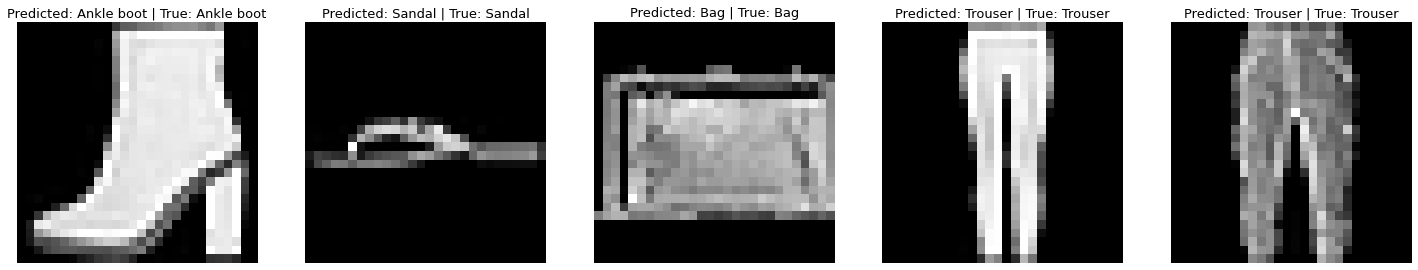

In [ ]:
'''
PREDICTION OF 5 RANDOMLY SAMPLED IMAGES
'''

load_and_display(num_epochs=10, learning_rate=0.001, dropout_p=0.0)

#### Sampling one more time...

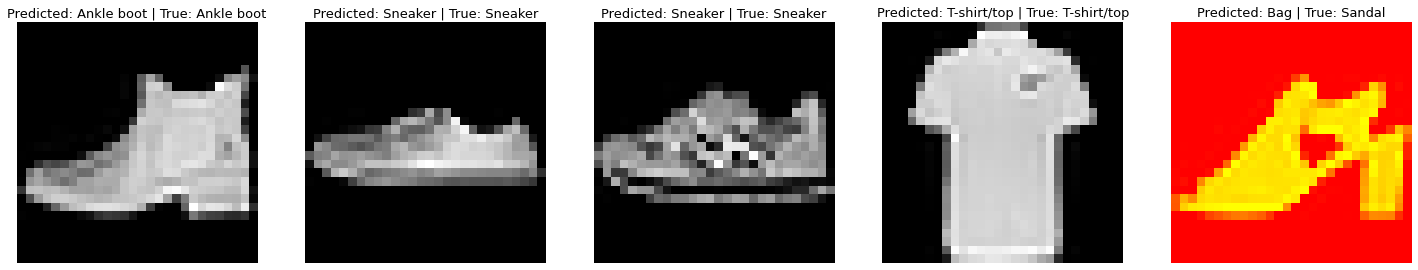

In [ ]:
load_and_display()

#### Sampling one more time...

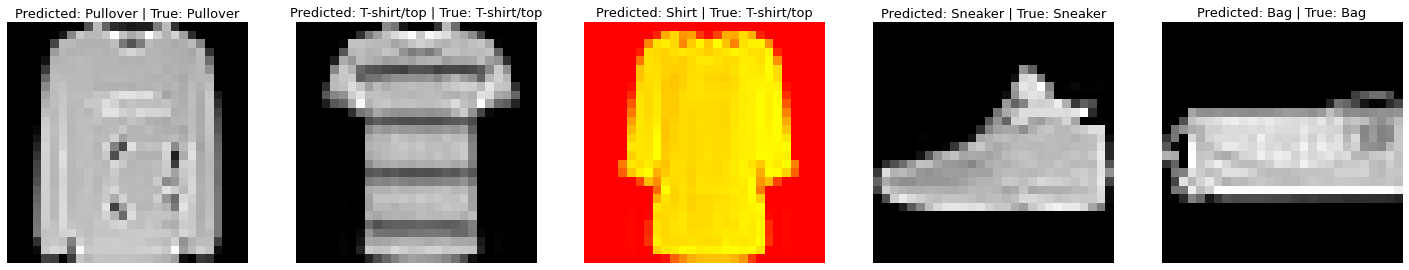

In [ ]:
load_and_display()

**Red Color  -> Misclassified**

**Gray Color -> Correctly Predicted**



---



**Below is the screenshot where I have tested on code with SonarQube for code vulnerabilites, bugs, smells and security hotspots.**

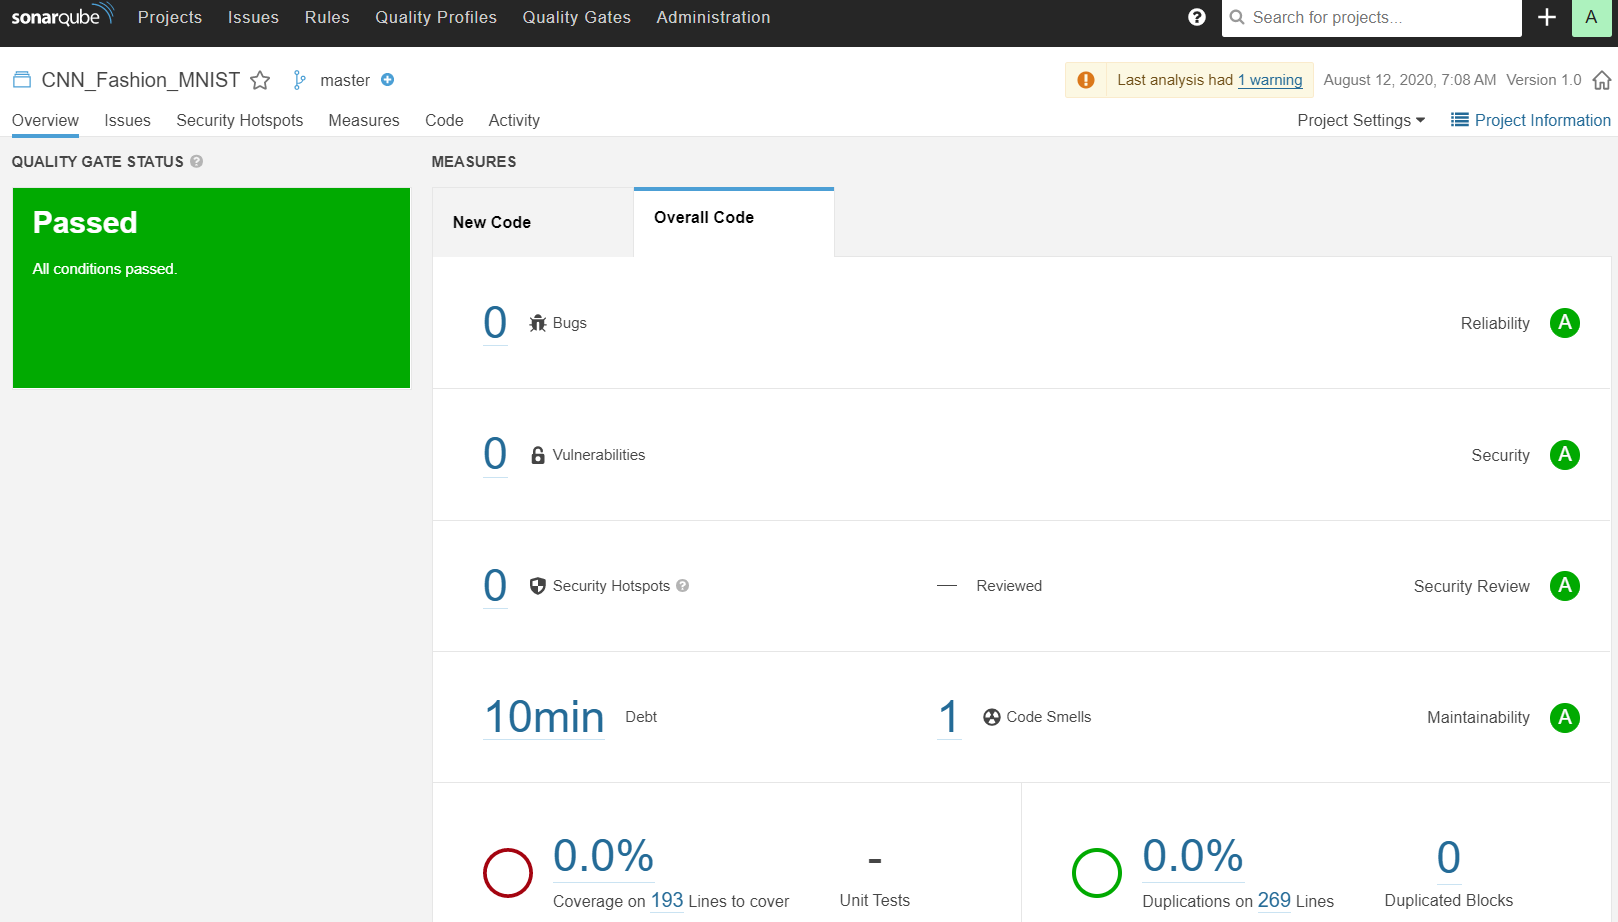

**No bug or vulnerabilites found in the code. But, there is a presence of 1 Code Smell. Let's analyze this in detail:**

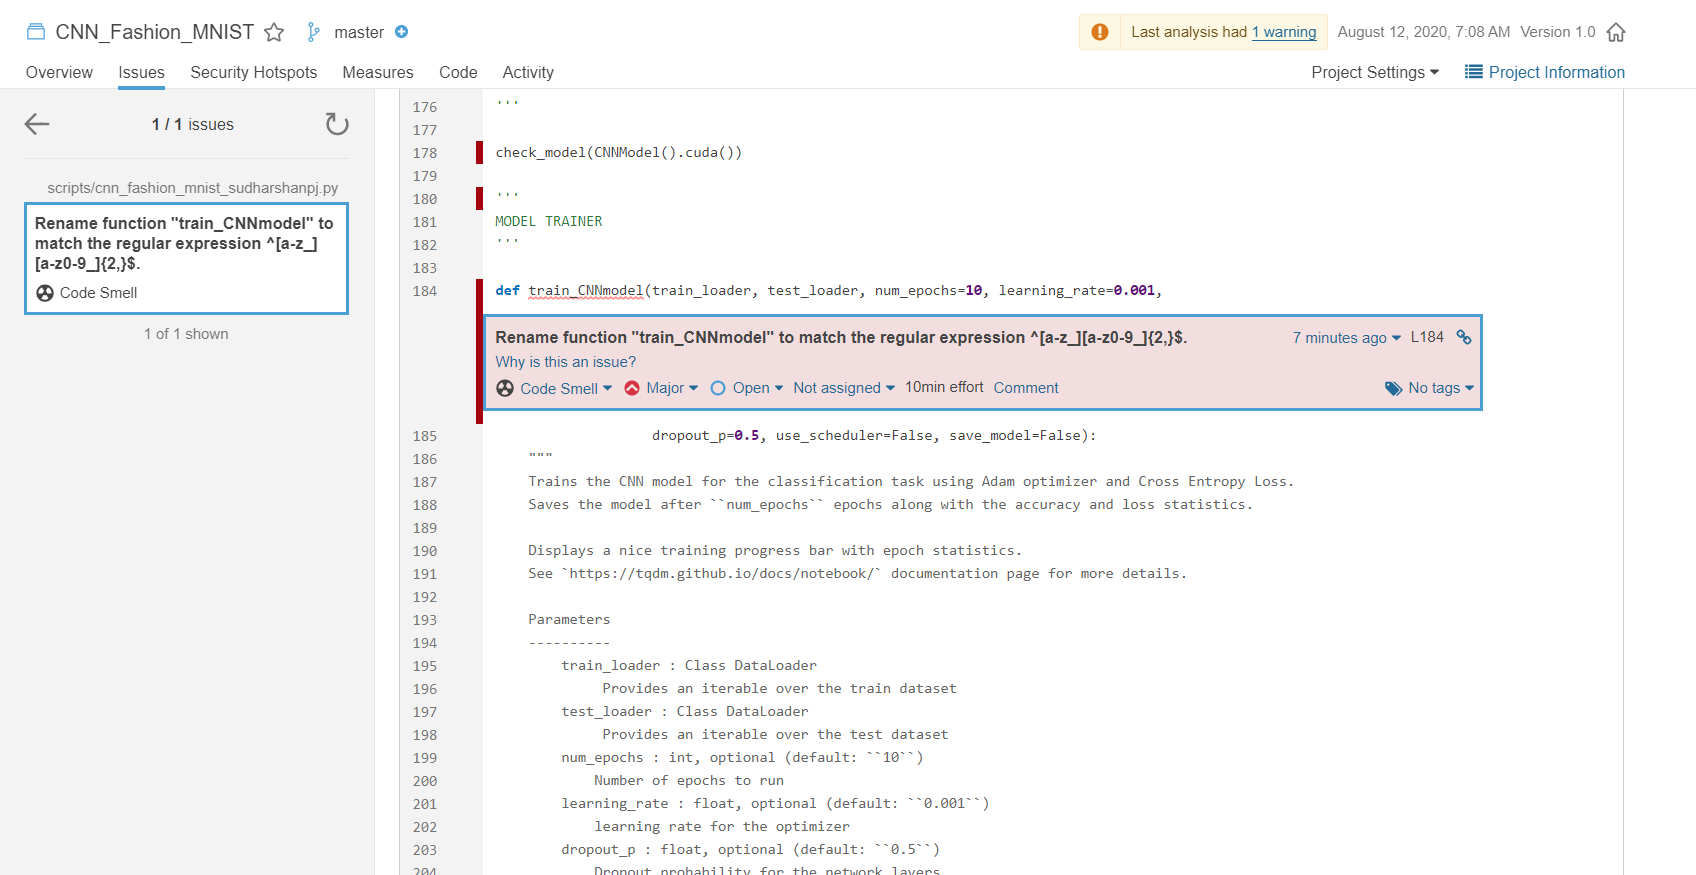

From the above, we can see that the code smell is caused by the function name not conforming with the PEP-8 standards. This is unavoidable in this case as the name of the function is kept to be "train_CNNmodel" for better readability (as CNN is an acronym) instead of naming it as "train_cnnmodel".

# Brief Analysis


*   For the optimizer, I have used the Adam as it is known to perform well for most of the cases. The loss function chosen for this task is cross-entropy loss. The reason why I chose is that the minimisation of the cross-entropy corresponds to the maximum likelihood estimation of the network parameters. 
Following provides an analogy for easy understanding: The negative log-likelihood becomes unhappy at smaller values and becomes less unhappy at larger values. Because when we are summing the loss function for the correct classes, what’s actually happening is that whenever the network assigns high confidence at the correct class, the unhappiness is low, but when the network assigns low confidence at the correct class, the unhappiness is high.

*   I have used RandomHorizontalFlip as the data augmentation method for the training set. Training with a multiple data augmentation methods like random crop, erasing, skew, flip helps the network generalize better as it provides an ability to train on the newly generated distribution which is more complex to fit and may represent the actual inference scenario. Other data augmentation methods like random crop, erasing, skew is not used here as these are more complex to fit and require more than 10 epochs of training. Nonetheless, for the above 2-convolutional layer model, it might be an overkill since the capacity of the network is less and worsens as we increase the dropout probability.

*   From the above curve fittings, we can see that the model with dropout probability (p)=0.0 provides better accuracy compared to the other models. This is expected, as retaining the connections with all the neurons helps us in inferring the output classes from the input features by learning the neuron weights. In the extreme case where p=0.999, we lose most of the connections from the output of the fully connected layer to the final layer. This results in information not being passed onto the final layer from the initial layers thereby resulting in poor performance of the classifier.

*   For the cases p=0.0, p=0.5 & p=0.7, we observe the test accuracy to be more than 80% just after one epoch of training.

*   For p=0.99 & p=0.999, after 1 epoch of training, there is no improvement in the test accuracy for the rest of the learning epochs.

*   From the slope of the curves, it is evident that p=0.9 has the highest rate of change of test accuracy between the epoch 10 and 1.

*   Sometimes, we might encounter the case where the network is a powerful one and then we start to overfit during training. This is clearly not the case here as from the epoch training stats, we can decipher that the test accuracy is much higher for dropout probability = 0.0. If it was overfitting, we would notice the training loss to be almost negligible and the classifier performing poorly on the test set. In addition to this, it is interesting to note a gradual decline in test accuracy as we increase the dropout probability and then it steeply comes down to almost 10% for the case when p=0.999. This gives an intuition that using p>=0.9 does not opportunistically train the model for our case and should be avoided.


*   It is better to have a separate test set which would give an idea of the generalization performance of the model. In the above case, we have actually been using the Fashion MNIST test set as an epoch validation set. We might risk overfitting on this test set as we train across many epochs and we would be left with no data to check the model generalization capacity.



---

